# Regression in Python

***
This is a very quick run-through of some basic statistical concepts, adapted from [Lab 4 in Harvard's CS109](https://github.com/cs109/2015lab4) course. Please feel free to try the original lab if you're feeling ambitious :-) The CS109 git repository also has the solutions if you're stuck.

* Linear Regression Models
* Prediction using linear regression
* Some re-sampling methods    
    * Train-Test splits
    * Cross Validation

Linear regression is used to model and predict continuous outcomes while logistic regression is used to model binary outcomes. We'll see some examples of linear regression as well as Train-test splits.


The packages we'll cover are: `statsmodels`, `seaborn`, and `scikit-learn`. While we don't explicitly teach `statsmodels` and `seaborn` in the Springboard workshop, those are great libraries to know.
***

<img width=600 height=300 src="https://imgs.xkcd.com/comics/sustainable.png"/>
***

In [307]:
# special IPython command to prepare the notebook for matplotlib and other libraries
%pylab inline 

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn

import seaborn as sns


from sklearn.cross_validation import cross_val_score

# special matplotlib argument for improved plots
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")

Populating the interactive namespace from numpy and matplotlib


***
# Part 1: Linear Regression
### Purpose of linear regression
***
<div class="span5 alert alert-info">

<p> Given a dataset $X$ and $Y$, linear regression can be used to: </p>
<ul>
  <li> Build a <b>predictive model</b> to predict future values of $X_i$ without a $Y$ value.  </li>
  <li> Model the <b>strength of the relationship</b> between each dependent variable $X_i$ and $Y$</li>
    <ul>
      <li> Sometimes not all $X_i$ will have a relationship with $Y$</li>
      <li> Need to figure out which $X_i$ contributes most information to determine $Y$ </li>
    </ul>
   <li>Linear regression is used in so many applications that I won't warrant this with examples. It is in many cases, the first pass prediction algorithm for continuous outcomes. </li>
</ul>
</div>

### A brief recap (feel free to skip if you don't care about the math)
***

[Linear Regression](http://en.wikipedia.org/wiki/Linear_regression) is a method to model the relationship between a set of independent variables $X$ (also knowns as explanatory variables, features, predictors) and a dependent variable $Y$.  This method assumes the relationship between each predictor $X$ is linearly related to the dependent variable $Y$.  

$$ Y = \beta_0 + \beta_1 X + \epsilon$$

where $\epsilon$ is considered as an unobservable random variable that adds noise to the linear relationship. This is the simplest form of linear regression (one variable), we'll call this the simple model. 

* $\beta_0$ is the intercept of the linear model

* Multiple linear regression is when you have more than one independent variable
    * $X_1$, $X_2$, $X_3$, $\ldots$

$$ Y = \beta_0 + \beta_1 X_1 + \ldots + \beta_p X_p + \epsilon$$ 

* Back to the simple model. The model in linear regression is the *conditional mean* of $Y$ given the values in $X$ is expressed a linear function.  

$$ y = f(x) = E(Y | X = x)$$ 

![conditional mean](images/conditionalmean.png)
http://www.learner.org/courses/againstallodds/about/glossary.html

* The goal is to estimate the coefficients (e.g. $\beta_0$ and $\beta_1$). We represent the estimates of the coefficients with a "hat" on top of the letter.  

$$ \hat{\beta}_0, \hat{\beta}_1 $$

* Once you estimate the coefficients $\hat{\beta}_0$ and $\hat{\beta}_1$, you can use these to predict new values of $Y$

$$\hat{y} = \hat{\beta}_0 + \hat{\beta}_1 x_1$$


* How do you estimate the coefficients? 
    * There are many ways to fit a linear regression model
    * The method called **least squares** is one of the most common methods
    * We will discuss least squares today
    
#### Estimating $\hat\beta$: Least squares
***
[Least squares](http://en.wikipedia.org/wiki/Least_squares) is a method that can estimate the coefficients of a linear model by minimizing the difference between the following: 

$$ S = \sum_{i=1}^N r_i = \sum_{i=1}^N (y_i - (\beta_0 + \beta_1 x_i))^2 $$

where $N$ is the number of observations.  

* We will not go into the mathematical details, but the least squares estimates $\hat{\beta}_0$ and $\hat{\beta}_1$ minimize the sum of the squared residuals $r_i = y_i - (\beta_0 + \beta_1 x_i)$ in the model (i.e. makes the difference between the observed $y_i$ and linear model $\beta_0 + \beta_1 x_i$ as small as possible). 

The solution can be written in compact matrix notation as

$$\hat\beta =  (X^T X)^{-1}X^T Y$$ 

We wanted to show you this in case you remember linear algebra, in order for this solution to exist we need $X^T X$ to be invertible. Of course this requires a few extra assumptions, $X$ must be full rank so that $X^T X$ is invertible, etc. **This is important for us because this means that having redundant features in our regression models will lead to poorly fitting (and unstable) models.** We'll see an implementation of this in the extra linear regression example.

**Note**: The "hat" means it is an estimate of the coefficient.  

***
# Part 2: Boston Housing Data Set

The [Boston Housing data set](https://archive.ics.uci.edu/ml/datasets/Housing) contains information about the housing values in suburbs of Boston.  This dataset was originally taken from the StatLib library which is maintained at Carnegie Mellon University and is now available on the UCI Machine Learning Repository. 


## Load the Boston Housing data set from `sklearn`
***

This data set is available in the [sklearn](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html#sklearn.datasets.load_boston) python module which is how we will access it today.  

In [308]:
from sklearn.datasets import load_boston
boston = load_boston()

In [309]:
boston.keys()

['data', 'feature_names', 'DESCR', 'target']

In [310]:
boston.data.shape

(506L, 13L)

In [311]:
# Print column names
print boston.feature_names

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'TAX' 'PTRATIO'
 'B' 'LSTAT']


In [312]:
# Print description of Boston housing data set
print boston.DESCR

Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
      

Now let's explore the data set itself. 

In [313]:
bos = pd.DataFrame(boston.data)
bos.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98
1,0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14
2,0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
3,0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94
4,0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33


There are no column names in the DataFrame. Let's add those. 

In [314]:
bos.columns = boston.feature_names
bos.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98
1,0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14
2,0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03
3,0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94
4,0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33


Now we have a pandas DataFrame called `bos` containing all the data we want to use to predict Boston Housing prices.  Let's create a variable called `PRICE` which will contain the prices. This information is contained in the `target` data. 

In [315]:
print boston.target.shape

(506L,)


In [316]:
bos['PRICE'] = boston.target
bos.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


## EDA and Summary Statistics
***

Let's explore this data set.  First we use `describe()` to get basic summary statistics for each of the columns. 

In [317]:
bos.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.593761,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.596783,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.647423,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


### Scatter plots
***

Let's look at some scatter plots for three variables: 'CRIM', 'RM' and 'PTRATIO'. 

What kind of relationship do you see? e.g. positive, negative?  linear? non-linear? 

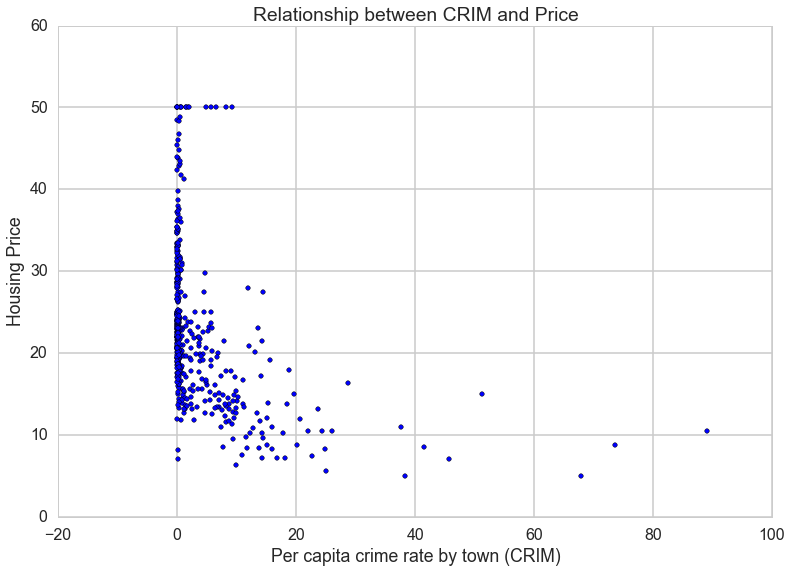

In [318]:
plt.scatter(bos.CRIM, bos.PRICE)
plt.xlabel("Per capita crime rate by town (CRIM)")
plt.ylabel("Housing Price")
plt.title("Relationship between CRIM and Price")

**Your turn**: Create scatter plots between *RM* and *PRICE*, and *PTRATIO* and *PRICE*. What do you notice? 

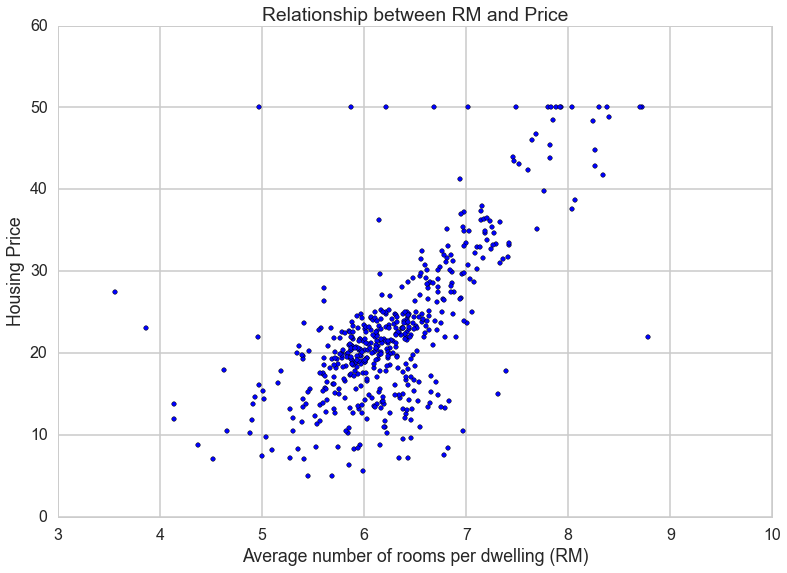

In [319]:
#your turn: scatter plot between *RM* and *PRICE*
plt.scatter(bos.RM, bos.PRICE)
plt.xlabel("Average number of rooms per dwelling (RM)")
plt.ylabel("Housing Price")
plt.title("Relationship between RM and Price")

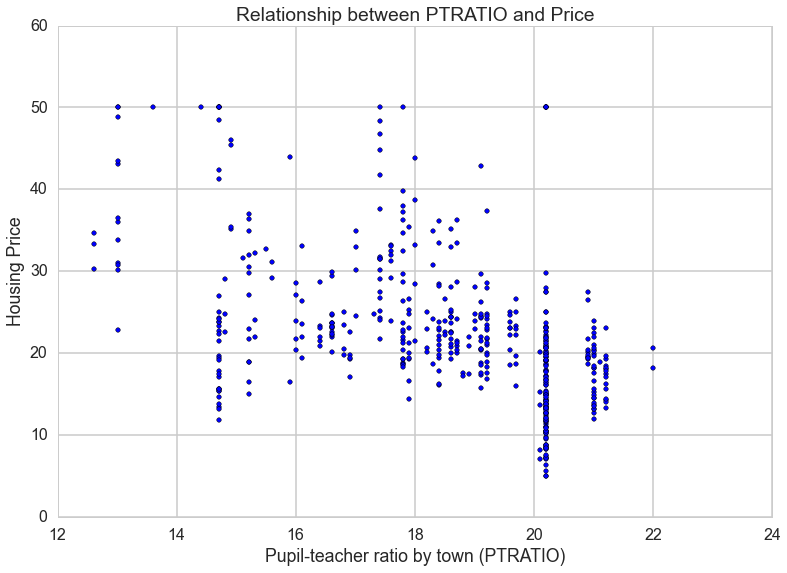

In [320]:
#your turn: scatter plot between *PTRATIO* and *PRICE*
plt.scatter(bos.PTRATIO, bos.PRICE)
plt.xlabel("Pupil-teacher ratio by town (PTRATIO)")
plt.ylabel("Housing Price")
plt.title("Relationship between PTRATIO and Price")

**Your turn**: What are some other numeric variables of interest? Plot scatter plots with these variables and *PRICE*.

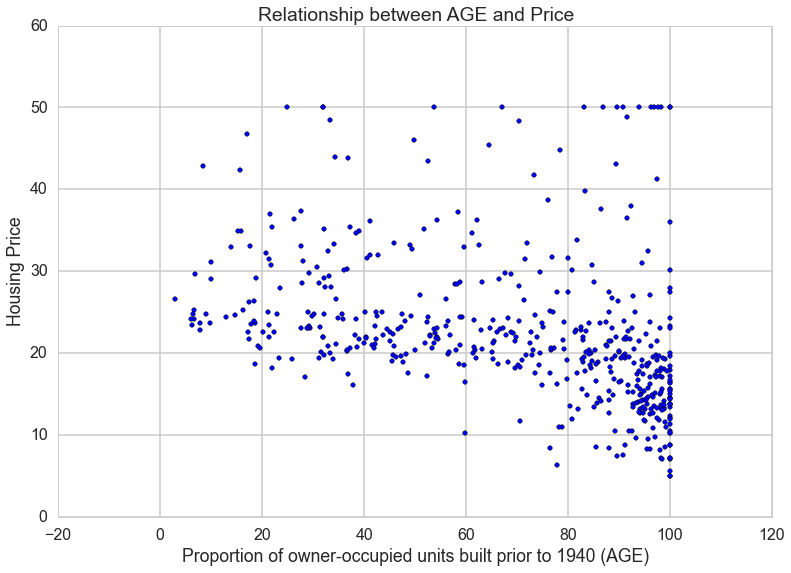

In [321]:
#your turn: create some other scatter plots
plt.scatter(bos.AGE, bos.PRICE)
plt.xlabel("Proportion of owner-occupied units built prior to 1940 (AGE)")
plt.ylabel("Housing Price")
plt.title("Relationship between AGE and Price")

### Scatter Plots using Seaborn
***

[Seaborn](https://stanford.edu/~mwaskom/software/seaborn/) is a cool Python plotting library built on top of matplotlib. It provides convenient syntax and shortcuts for many common types of plots, along with better-looking defaults.

We can also use [seaborn regplot](https://stanford.edu/~mwaskom/software/seaborn/tutorial/regression.html#functions-to-draw-linear-regression-models) for the scatterplot above. This provides automatic linear regression fits (useful for data exploration later on). Here's one example below.

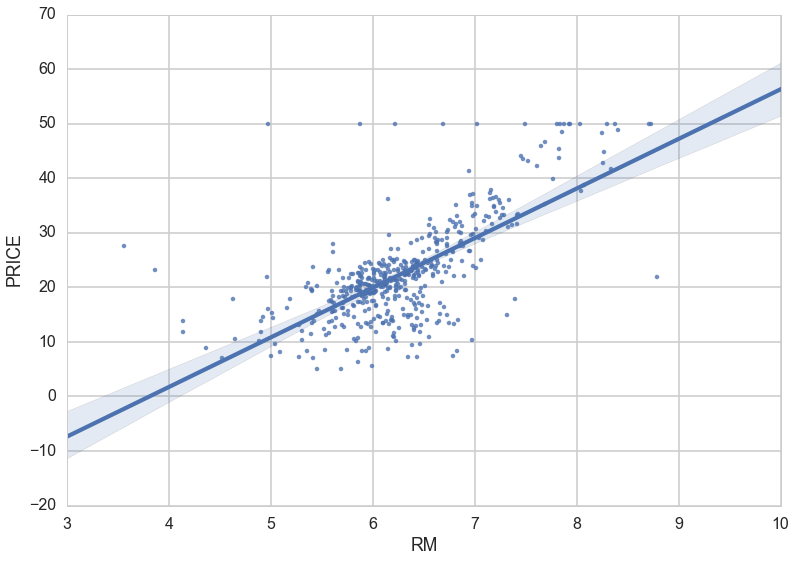

In [322]:
sns.regplot(y="PRICE", x="RM", data=bos, fit_reg = True)

### Histograms
***


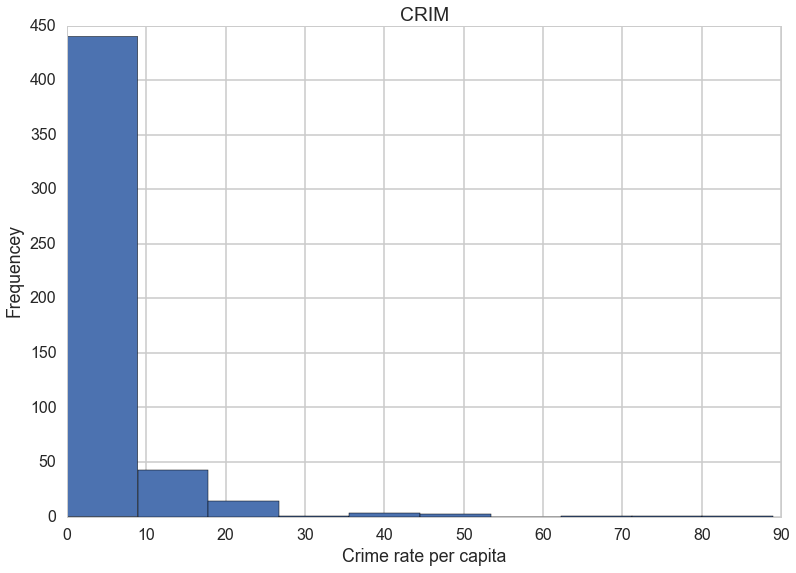

In [323]:
plt.hist(bos.CRIM)
plt.title("CRIM")
plt.xlabel("Crime rate per capita")
plt.ylabel("Frequencey")
plt.show()

**Your turn**:

* Plot histograms for *RM* and *PTRATIO*, along with the two variables you picked in the previous section.

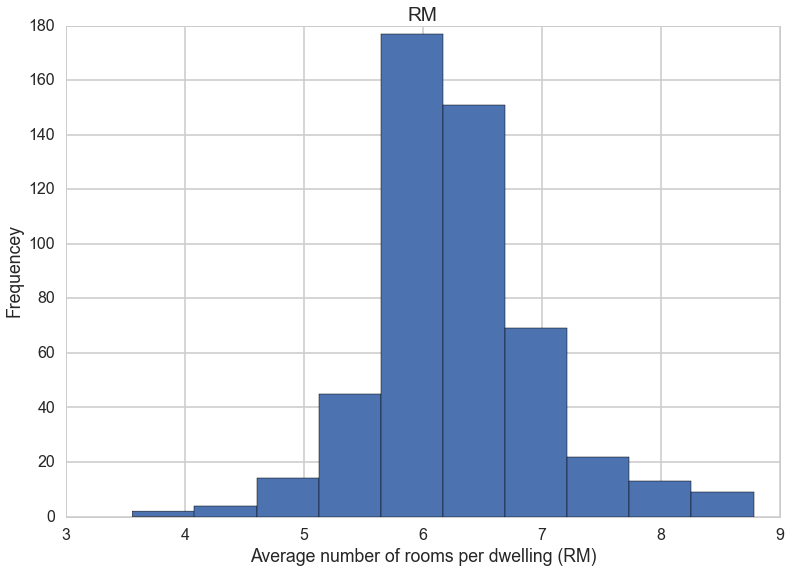

In [324]:
#your turn
plt.hist(bos.RM)
plt.title("RM")
plt.xlabel("Average number of rooms per dwelling (RM)")
plt.ylabel("Frequencey")
plt.show()

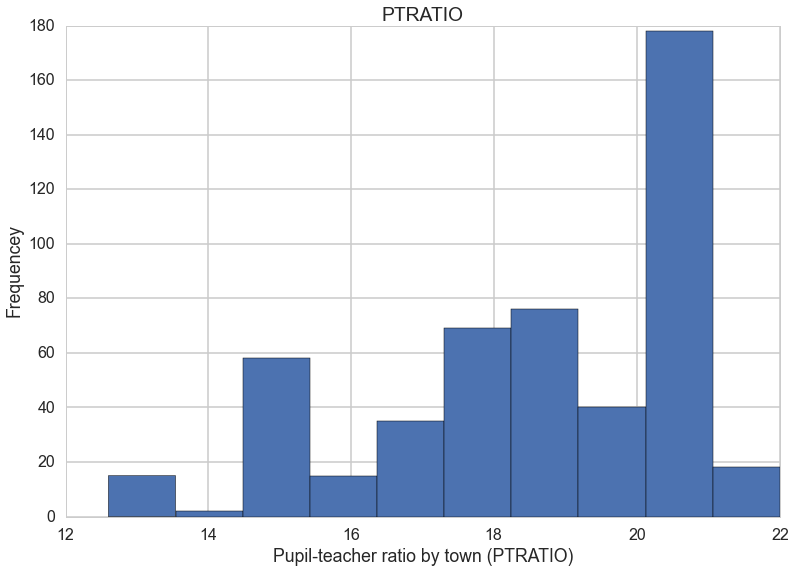

In [325]:
plt.hist(bos.PTRATIO)
plt.title("PTRATIO")
plt.xlabel("Pupil-teacher ratio by town (PTRATIO)")
plt.ylabel("Frequencey")
plt.show()

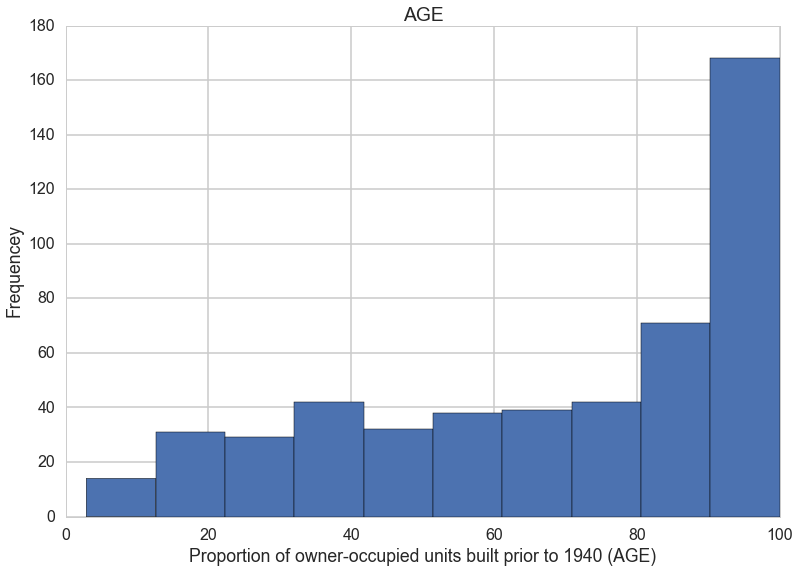

In [326]:
plt.hist(bos.AGE)
plt.title("AGE")
plt.xlabel("Proportion of owner-occupied units built prior to 1940 (AGE)")
plt.ylabel("Frequencey")
plt.show()

## Linear regression with  Boston housing data example
***

Here, 

$Y$ = boston housing prices (also called "target" data in python)

and

$X$ = all the other features (or independent variables)

which we will use to fit a linear regression model and predict Boston housing prices. We will use the least squares method as the way to estimate the coefficients.  

We'll use two ways of fitting a linear regression. We recommend the first but the second is also powerful in its features.

### Fitting Linear Regression using `statsmodels`
***
[Statsmodels](http://statsmodels.sourceforge.net/) is a great Python library for a lot of basic and inferential statistics. It also provides basic regression functions using an R-like syntax, so it's commonly used by statisticians. While we don't cover statsmodels officially in the Data Science Intensive, it's a good library to have in your toolbox. Here's a quick example of what you could do with it.

In [327]:
# Import regression modules
# ols - stands for Ordinary least squares, we'll use this
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [328]:
# statsmodels works nicely with pandas dataframes
# The thing inside the "quotes" is called a formula, a bit on that below
m = ols('PRICE ~ RM',bos).fit()
print m.summary()

                            OLS Regression Results                            
Dep. Variable:                  PRICE   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.483
Method:                 Least Squares   F-statistic:                     471.8
Date:                Mon, 22 Aug 2016   Prob (F-statistic):           2.49e-74
Time:                        20:48:11   Log-Likelihood:                -1673.1
No. Observations:                 506   AIC:                             3350.
Df Residuals:                     504   BIC:                             3359.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    -34.6706      2.650    -13.084      0.0

#### Interpreting coefficients

There is a ton of information in this output. But we'll concentrate on the coefficient table (middle table). We can interpret the `RM` coefficient (9.1021) by first noticing that the p-value (under `P>|t|`) is so small, basically zero. We can interpret the coefficient as, if we compare two groups of towns, one where the average number of rooms is say $5$ and the other group is the same except that they all have $6$ rooms. For these two groups the average difference in house prices is about $9.1$ (in thousands) so about $\$9,100$ difference. The confidence interval fives us a range of plausible values for this difference, about ($\$8,279, \$9,925$), deffinitely not chump change. 

####  `statsmodels` formulas
***
This formula notation will seem familiar to `R` users, but will take some getting used to for people coming from other languages or are new to statistics.

The formula gives instruction for a general structure for a regression call. For `statsmodels` (`ols` or `logit`) calls you need to have a Pandas dataframe with column names that you will add to your formula. In the below example you need a pandas data frame that includes the columns named (`Outcome`, `X1`,`X2`, ...), bbut you don't need to build a new dataframe for every regression. Use the same dataframe with all these things in it. The structure is very simple:

`Outcome ~ X1`

But of course we want to to be able to handle more complex models, for example multiple regression is doone like this:

`Outcome ~ X1 + X2 + X3`

This is the very basic structure but it should be enough to get you through the homework. Things can get much more complex, for a quick run-down of further uses see the `statsmodels` [help page](http://statsmodels.sourceforge.net/devel/example_formulas.html).


Let's see how our model actually fit our data. We can see below that there is a ceiling effect, we should probably look into that. Also, for large values of $Y$ we get underpredictions, most predictions are below the 45-degree gridlines. 

**Your turn:** Create a scatterpot between the predicted prices, available in `m.fittedvalues` and the original prices. How does the plot look?

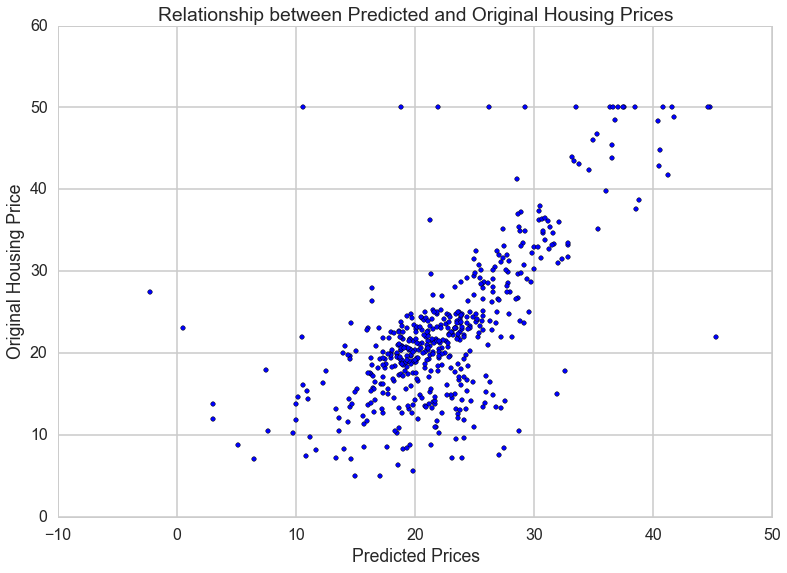

In [329]:
# your turn
plt.scatter(m.fittedvalues, bos.PRICE)
plt.xlabel("Predicted Prices")
plt.ylabel("Original Housing Price")
plt.title("Relationship between Predicted and Original Housing Prices")

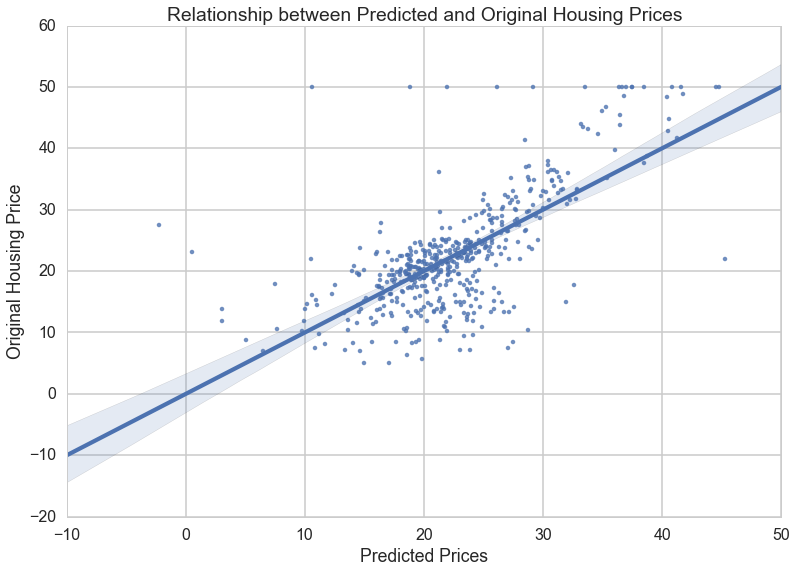

In [330]:
sns.regplot(y=bos.PRICE, x=m.fittedvalues, fit_reg = True)
plt.xlabel("Predicted Prices")
plt.ylabel("Original Housing Price")
plt.title("Relationship between Predicted and Original Housing Prices")

### Fitting Linear Regression using `sklearn`


In [331]:
from sklearn.linear_model import LinearRegression
X = bos.drop('PRICE', axis = 1)

# This creates a LinearRegression object
lm = LinearRegression()
lm

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

#### What can you do with a LinearRegression object? 
***
Check out the scikit-learn [docs here](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). We have listed the main functions here.

Main functions | Description
--- | --- 
`lm.fit()` | Fit a linear model
`lm.predit()` | Predict Y using the linear model with estimated coefficients
`lm.score()` | Returns the coefficient of determination (R^2). *A measure of how well observed outcomes are replicated by the model, as the proportion of total variation of outcomes explained by the model*

#### What output can you get?

In [332]:
# Look inside lm object
# lm.<tab>

Output | Description
--- | --- 
`lm.coef_` | Estimated coefficients
`lm.intercept_` | Estimated intercept 

### Fit a linear model
***

The `lm.fit()` function estimates the coefficients the linear regression using least squares. 

In [333]:
# Use all 13 predictors to fit linear regression model
lm.fit(X, bos.PRICE)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

**Your turn:** How would you change the model to not fit an intercept term? Would you recommend not having an intercept?


In [334]:
lm1 = LinearRegression(fit_intercept=False)
lm1
lm1.fit(X, bos.PRICE)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

### Estimated intercept and coefficients

Let's look at the estimated coefficients from the linear model using `1m.intercept_` and `lm.coef_`.  

After we have fit our linear regression model using the least squares method, we want to see what are the estimates of our coefficients $\beta_0$, $\beta_1$, ..., $\beta_{13}$: 

$$ \hat{\beta}_0, \hat{\beta}_1, \ldots, \hat{\beta}_{13} $$



In [335]:
print 'Estimated intercept coefficient:', lm.intercept_

Estimated intercept coefficient: 36.4911032804


In [336]:
print 'Number of coefficients:', len(lm.coef_)

Number of coefficients: 13


In [337]:
# The coefficients
pd.DataFrame(zip(X.columns, lm.coef_), columns = ['features', 'estimatedCoefficients'])

,features,estimatedCoefficients
0,CRIM,-0.107171
1,ZN,0.046395
2,INDUS,0.020860
3,CHAS,2.688561
4,NOX,-17.795759
5,RM,3.804752
6,AGE,0.000751
7,DIS,-1.475759
8,RAD,0.305655
9,TAX,-0.012329


### Predict Prices 

We can calculate the predicted prices ($\hat{Y}_i$) using `lm.predict`. 

$$ \hat{Y}_i = \hat{\beta}_0 + \hat{\beta}_1 X_1 + \ldots \hat{\beta}_{13} X_{13} $$

In [338]:
# first five predicted prices
lm.predict(X)[0:5]

array([ 30.00821269,  25.0298606 ,  30.5702317 ,  28.60814055,  27.94288232])

**Your turn:** 

* Histogram: Plot a histogram of all the predicted prices
* Scatter Plot: Let's plot the true prices compared to the predicted prices to see they disagree (we did this with `statsmodels` before).

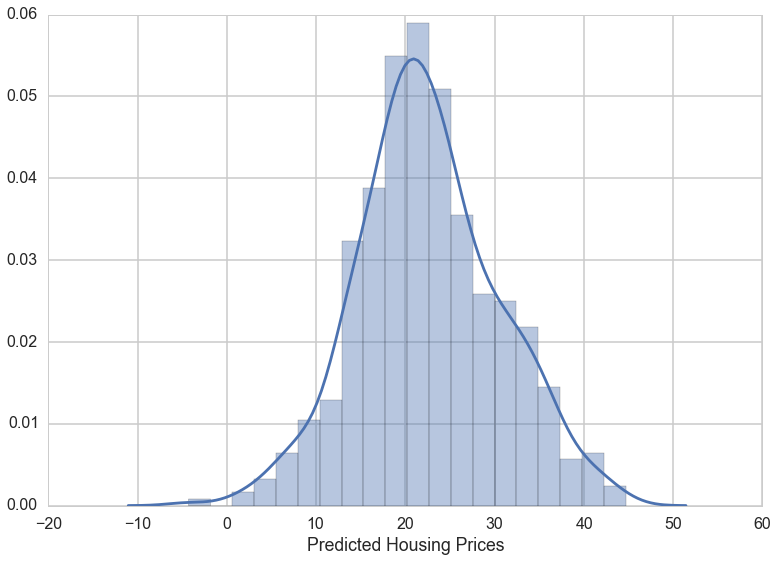

In [339]:
# your turn
sns.distplot(lm.predict(X),axlabel="Predicted Housing Prices")

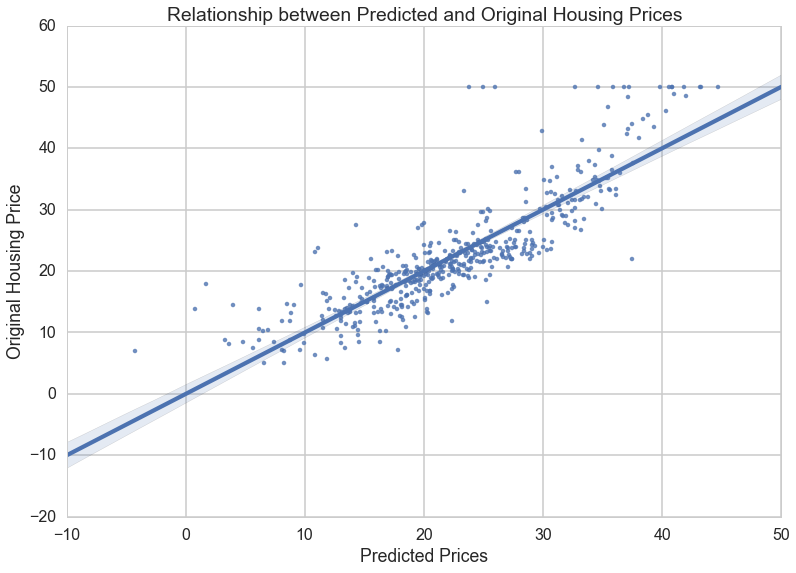

In [340]:
sns.regplot(y=bos.PRICE, x=lm.predict(X), fit_reg = True)
plt.xlabel("Predicted Prices")
plt.ylabel("Original Housing Price")
plt.title("Relationship between Predicted and Original Housing Prices")

### Residual sum of squares

Let's calculate the residual sum of squares 

$$ S = \sum_{i=1}^N r_i = \sum_{i=1}^N (y_i - (\beta_0 + \beta_1 x_i))^2 $$

In [341]:
print np.sum((bos.PRICE - lm.predict(X)) ** 2)

11080.2762841


#### Mean squared error
***
This is simple the mean of the residual sum of squares.

**Your turn:** Calculate the mean squared error and print it.

In [342]:
#your turn
print np.mean((bos.PRICE - lm.predict(X)) ** 2)

21.8977792177


## Relationship between `PTRATIO` and housing price
***

Try fitting a linear regression model using only the 'PTRATIO' (pupil-teacher ratio by town)

Calculate the mean squared error. 


In [343]:
lm = LinearRegression()
lm.fit(X[['PTRATIO']], bos.PRICE)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [344]:
msePTRATIO = np.mean((bos.PRICE - lm.predict(X[['PTRATIO']])) ** 2)
print msePTRATIO

62.6522000138


We can also plot the fitted linear regression line. 

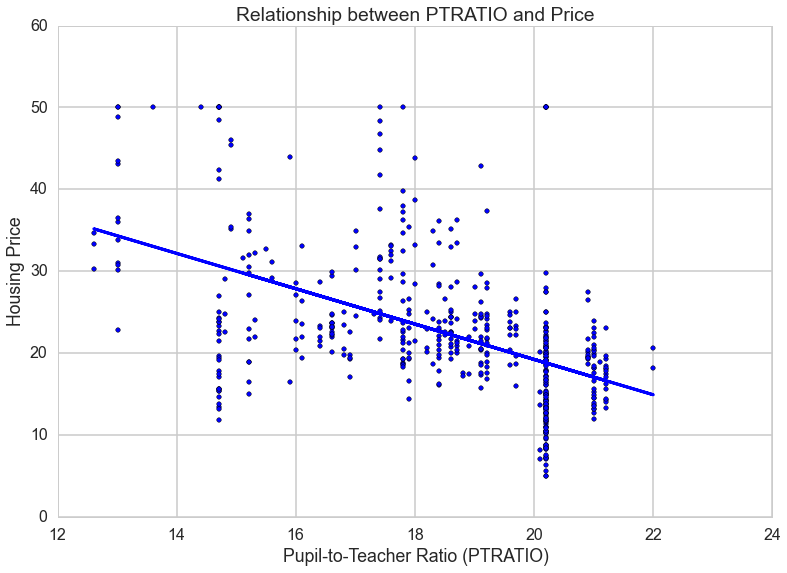

In [345]:
plt.scatter(bos.PTRATIO, bos.PRICE)
plt.xlabel("Pupil-to-Teacher Ratio (PTRATIO)")
plt.ylabel("Housing Price")
plt.title("Relationship between PTRATIO and Price")

plt.plot(bos.PTRATIO, lm.predict(X[['PTRATIO']]), color='blue', linewidth=3)
plt.show()

# Your turn
***

Try fitting a linear regression model using three independent variables

1. 'CRIM' (per capita crime rate by town)
2. 'RM' (average number of rooms per dwelling)
3. 'PTRATIO' (pupil-teacher ratio by town)

Calculate the mean squared error. 

In [346]:
# your turn
lm = LinearRegression()
lm.fit(X[['CRIM','RM','PTRATIO']], bos.PRICE)
mseall = np.mean((bos.PRICE - lm.predict(X[['CRIM','RM','PTRATIO']])) ** 2)
print mseall

34.3237965647



## Other important things to think about when fitting a linear regression model
***
<div class="span5 alert alert-danger">
<ul>
  <li>**Linearity**. The dependent variable $Y$ is a linear combination of the regression coefficients and the independent variables $X$. </li>
  <li>**Constant standard deviation**. The SD of the dependent variable $Y$ should be constant for different values of X.  
        <ul>
            <li>e.g. PTRATIO
        </ul>
    </li>
  <li> **Normal distribution for errors**.  The $\epsilon$ term we discussed at the beginning are assumed to be normally distributed. 
  $$ \epsilon_i \sim N(0, \sigma^2)$$
Sometimes the distributions of responses $Y$ may not be normally distributed at any given value of $X$.  e.g. skewed positively or negatively. </li>
<li> **Independent errors**.  The observations are assumed to be obtained independently.
    <ul>
        <li>e.g. Observations across time may be correlated
    </ul>
</li>
</ul>  

</div>


# Part 3: Training and Test Data sets

### Purpose of splitting data into Training/testing sets
***
<div class="span5 alert alert-info">

<p> Let's stick to the linear regression example: </p>
<ul>
  <li> We built our model with the requirement that the model fit the data well. </li>
  <li> As a side-effect, the model will fit <b>THIS</b> dataset well. What about new data? </li>
    <ul>
      <li> We wanted the model for predictions, right?</li>
    </ul>
  <li> One simple solution, leave out some data (for <b>testing</b>) and <b>train</b> the model on the rest </li>
  <li> This also leads directly to the idea of cross-validation, next section. </li>  
</ul>
</div>

***

One way of doing this is you can create training and testing data sets manually. 

In [347]:
X_train = X[:-50]
X_test = X[-50:]
Y_train = bos.PRICE[:-50]
Y_test = bos.PRICE[-50:]
print X_train.shape
print X_test.shape
print Y_train.shape
print Y_test.shape

(456, 13)
(50, 13)
(456L,)
(50L,)


Another way, is to split the data into random train and test subsets using the function `train_test_split` in `sklearn.cross_validation`. Here's the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.train_test_split.html).

In [348]:
X_train, X_test, Y_train, Y_test = sklearn.cross_validation.train_test_split(
    X, bos.PRICE, test_size=0.33, random_state = 5)
print X_train.shape
print X_test.shape
print Y_train.shape
print Y_test.shape

(339, 13)
(167, 13)
(339L,)
(167L,)


**Your turn:**  Let's build a linear regression model using our new training data sets. 

* Fit a linear regression model to the training set
* Predict the output on the test set

In [349]:
# your turn
lm = LinearRegression()
lm.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

**Your turn:**

Calculate the mean squared error 

* using just the test data
* using just the training data

Are they pretty similar or very different? What does that mean?

In [350]:
# your turn
mse_train = np.mean((Y_train - lm.predict(X_train)) ** 2)
print mse_train
mse_test = np.mean((Y_test - lm.predict(X_test)) ** 2)
print mse_test

19.5467584735
28.5413672756


#### Residual plots

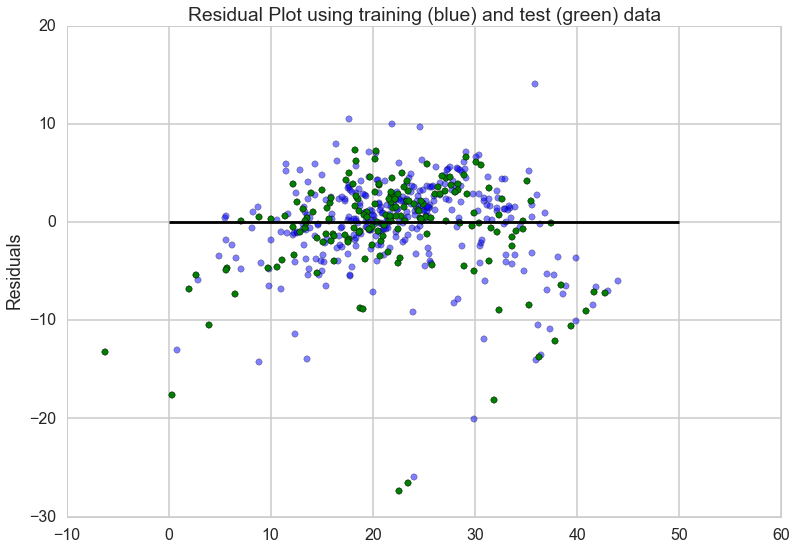

In [351]:
plt.scatter(lm.predict(X_train), lm.predict(X_train) - Y_train, c='b', s=40, alpha=0.5)
plt.scatter(lm.predict(X_test), lm.predict(X_test) - Y_test, c='g', s=40)
plt.hlines(y = 0, xmin=0, xmax = 50)
plt.title('Residual Plot using training (blue) and test (green) data')
plt.ylabel('Residuals')

**Your turn:** Do you think this linear regression model generalizes well on the test data?

### K-fold Cross-validation as an extension of this idea
***
<div class="span5 alert alert-info">

<p> A simple extension of the Test/train split is called K-fold cross-validation.  </p>

<p> Here's the procedure:</p>
<ul>
  <li> randomly assign your $n$ samples to one of $K$ groups. They'll each have about $n/k$ samples</li>
  <li> For each group $k$: </li>
    <ul>
      <li> Fit the model (e.g. run regression) on all data excluding the $k^{th}$ group</li>
      <li> Use the model to predict the outcomes in group $k$</li>
      <li> Calculate your prediction error for each observation in $k^{th}$ group (e.g. $(Y_i - \hat{Y}_i)^2$ for regression, $\mathbb{1}(Y_i = \hat{Y}_i)$ for logistic regression). </li>
    </ul>
  <li> Calculate the average prediction error across all samples $Err_{CV} = \frac{1}{n}\sum_{i=1}^n (Y_i - \hat{Y}_i)^2$ </li>
</ul>
</div>

***

Luckily you don't have to do this entire process all by hand (``for`` loops, etc.) every single time, ``sci-kit learn`` has a very nice implementation of this, have a look at the [documentation](http://scikit-learn.org/stable/modules/cross_validation.html).

**Your turn (extra credit):** Implement K-Fold cross-validation using the procedure above and Boston Housing data set using $K=4$. How does the average prediction error compare to the train-test split above?

In [352]:
print(np.sqrt(-cross_val_score(lm, X, bos.PRICE, cv=4, scoring='mean_squared_error')).mean())

6.27709662002
